In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from pmdarima import auto_arima
from matplotlib.dates import DateFormatter

In [2]:
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

In [3]:
df = pd.read_csv(r"C:\causal inference and causal ML\Dominicks\cola.csv")

In [4]:
df = df[['UPC','STORE', 'WEEK', 'brand', 'product_type_regular',
         'MOVE', 
         'log_price_1200000017', 'log_price_1200000053', 'log_price_4900001063','log_price_4900001278', 'promo', 'PROFIT']]

In [5]:
df.head()

,UPC,STORE,WEEK,brand,product_type_regular,MOVE,log_price_1200000017,log_price_1200000053,log_price_4900001063,log_price_4900001278,promo,PROFIT
0,1200000017,2,1,PEPSI,True,23,1.885553,1.885553,0.0,0.0,1,10.47
1,1200000017,2,2,PEPSI,True,6,2.078191,0.000000,0.0,0.0,0,26.16
2,1200000017,2,3,PEPSI,True,0,0.000000,0.000000,0.0,0.0,0,0.00
3,1200000017,2,4,PEPSI,True,29,2.078191,2.078191,0.0,0.0,0,26.16
4,1200000017,2,5,PEPSI,True,0,0.000000,0.000000,0.0,0.0,0,0.00


In [6]:
df.shape

(130224, 12)

In [9]:
df.describe()
# move is sales

,UPC,STORE,WEEK,MOVE,log_price_1200000017,log_price_1200000053,log_price_4900001063,log_price_4900001278,promo,PROFIT
count,1.302240e+05,130224.000000,130224.000000,130224.000000,130224.000000,130224.000000,130224.000000,130224.000000,130224.000000,130224.000000
mean,3.050001e+09,82.735379,203.300283,38.329548,1.676331,1.685333,1.634292,1.678772,0.306372,-0.411324
std,1.850008e+09,36.548425,114.795707,121.246873,0.680762,0.668784,0.731406,0.689230,0.460988,24.489790
min,1.200000e+09,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-99.910000
25%,1.200000e+09,54.000000,105.000000,3.000000,1.790091,1.790091,1.702928,1.790091,0.000000,-11.590000
50%,3.050001e+09,88.000000,201.000000,9.000000,1.944481,1.944481,1.945910,1.972691,0.000000,0.000000
75%,4.900001e+09,113.000000,305.000000,33.000000,2.026832,2.026832,2.026832,2.026832,1.000000,11.640000
max,4.900001e+09,146.000000,399.000000,9487.000000,2.150599,2.150599,2.150599,2.150599,1.000000,99.990000


In [15]:
df.isnull().sum()

UPC                     0
STORE                   0
WEEK                    0
brand                   0
product_type_regular    0
MOVE                    0
log_price_1200000017    0
log_price_1200000053    0
log_price_4900001063    0
log_price_4900001278    0
promo                   0
PROFIT                  0
dtype: int64

In [17]:
df.groupby('UPC')['STORE'].nunique()

UPC
1200000017    93
1200000053    93
4900001063    93
4900001278    93
Name: STORE, dtype: int64

### focus on stroe 2, the lowest store number

In [19]:
df2 = df[df['STORE']==2]

In [21]:
df.groupby('UPC')['WEEK'].nunique()

UPC
1200000017    390
1200000053    390
4900001063    390
4900001278    390
Name: WEEK, dtype: int64

### week index has missing, one is because of data quality issue (namely df['OK']!=1), others are missing from raw data

In [23]:
weeks_in_data = df2['WEEK'].unique()
all_weeks = set(range(1, 400))

missing_weeks = sorted(all_weeks - set(weeks_in_data))
print(missing_weeks)

[30, 49, 55, 56, 96, 101, 102, 219, 254, 255, 256, 257, 258, 259, 260, 261]


### complet week index to implement time series models, and fill missing values

In [25]:
all_weeks = pd.DataFrame({'WEEK': range(1, 400)})
store_upc_combinations = df2[['STORE', 'UPC']].drop_duplicates()
complete_index = (
    store_upc_combinations
    .merge(all_weeks, how='cross')
)
df2 = complete_index.merge(df2, on=['STORE', 'UPC', 'WEEK'], how='left')
print(df2.groupby('UPC')['WEEK'].nunique())

UPC
1200000017    399
1200000053    399
4900001063    399
4900001278    399
Name: WEEK, dtype: int64


In [27]:
df2 = df2.sort_values(['UPC','WEEK'])
df2['MOVE'] = df2['MOVE'].fillna(0)
df2['promo'] = df2['promo'].fillna(0)
df2['PROFIT'] = df2.groupby('UPC')['PROFIT'].transform(lambda x: x.ffill())
for v in ['log_price_1200000017', 'log_price_1200000053', 'log_price_4900001063','log_price_4900001278']:
    df2[v] = df2.groupby('UPC')[v].transform(lambda x: x.ffill())

In [29]:
df2['log_move'] = np.log(df2['MOVE']+1) # add 1 to avoid log failure when MOVE=0

### for each UPC: continuous blocks of zeros in about first 50 weeks, so exclude first 49 weeks to start from week 50

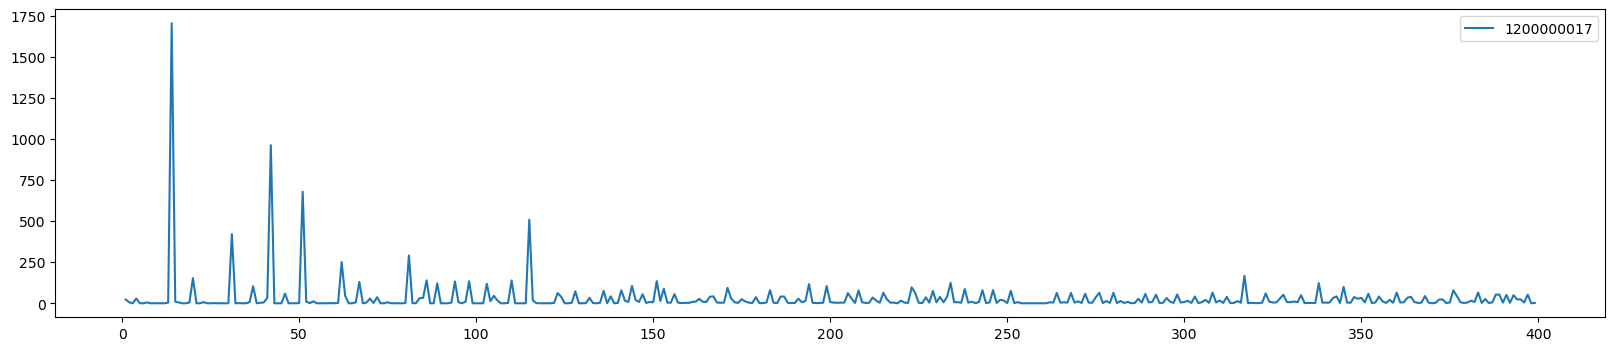

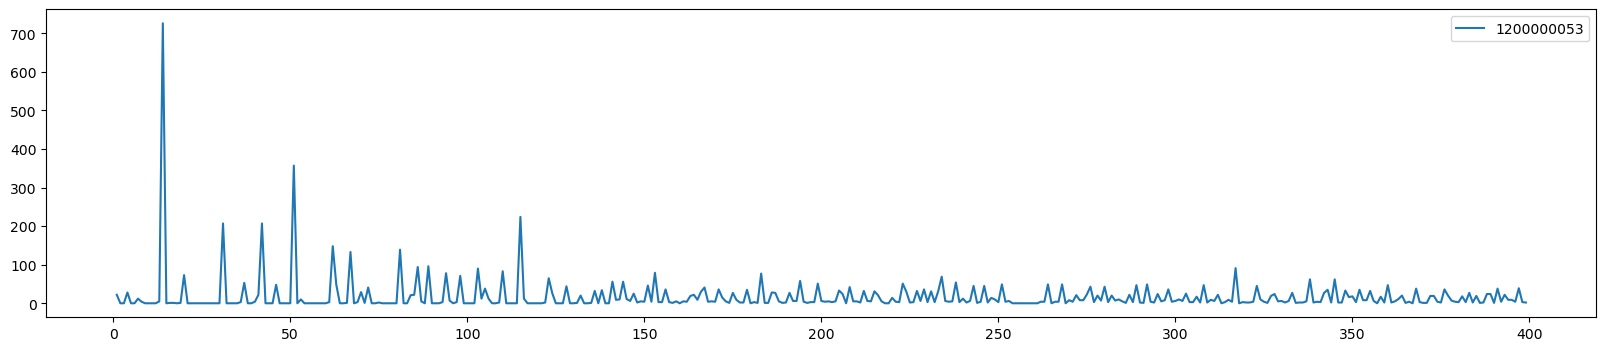

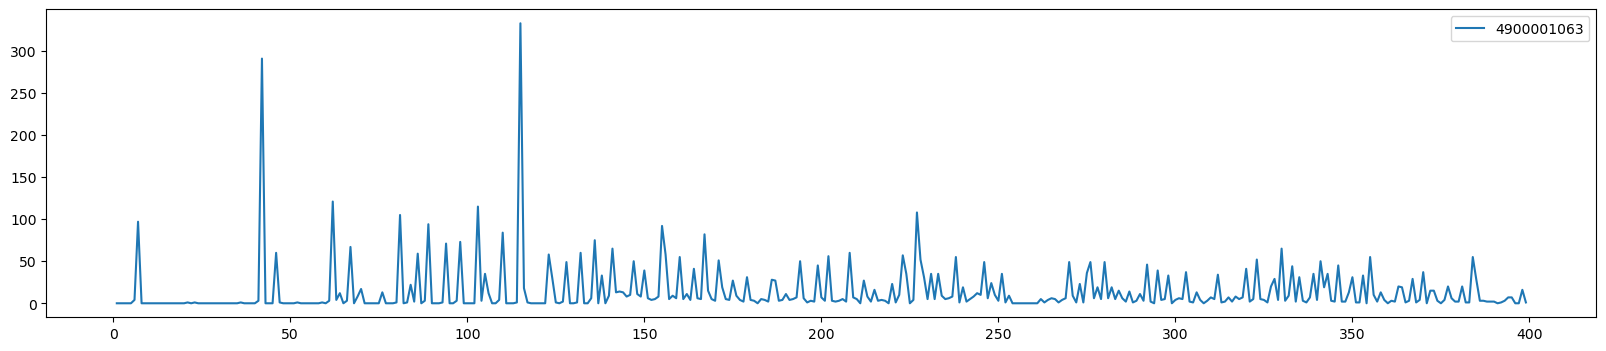

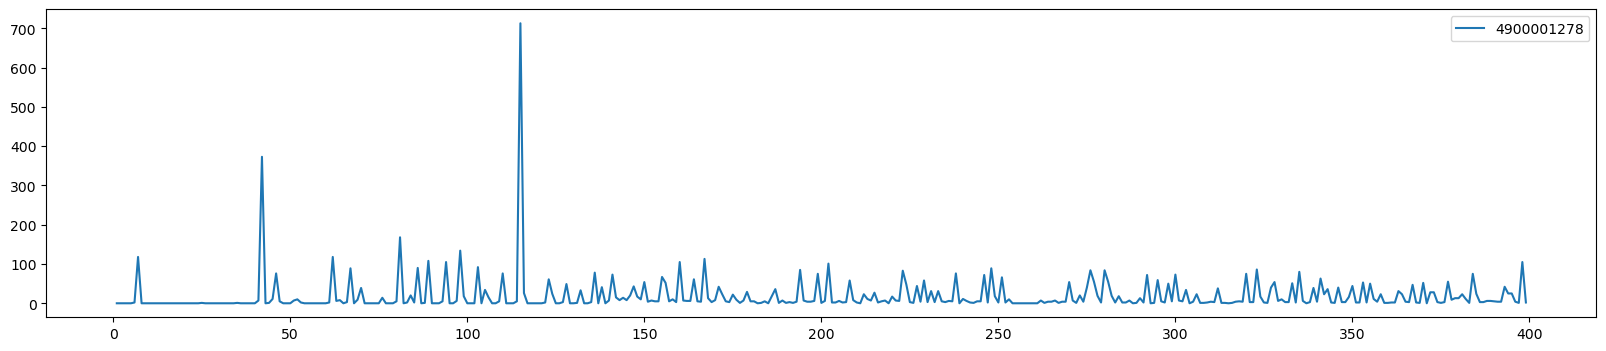

In [31]:
for upc in df['UPC'].unique():
    upc_data = df2[df2['UPC'] == upc]
    plt.figure(figsize=(20, 4))
    plt.plot(upc_data['WEEK'], upc_data['MOVE'], label=str(upc))
    plt.legend()
    plt.show()

In [33]:
df2 = df2[df2['WEEK']>=50]

In [35]:
start_date = pd.to_datetime("1989-09-14")
df2['DATE'] = df2['WEEK'].apply(lambda x: start_date + pd.Timedelta(weeks=int(x) - 1))

In [37]:
df2.to_csv(r"C:\causal inference and causal ML\Dominicks\cola_clean.csv",index=False)

### outlier check

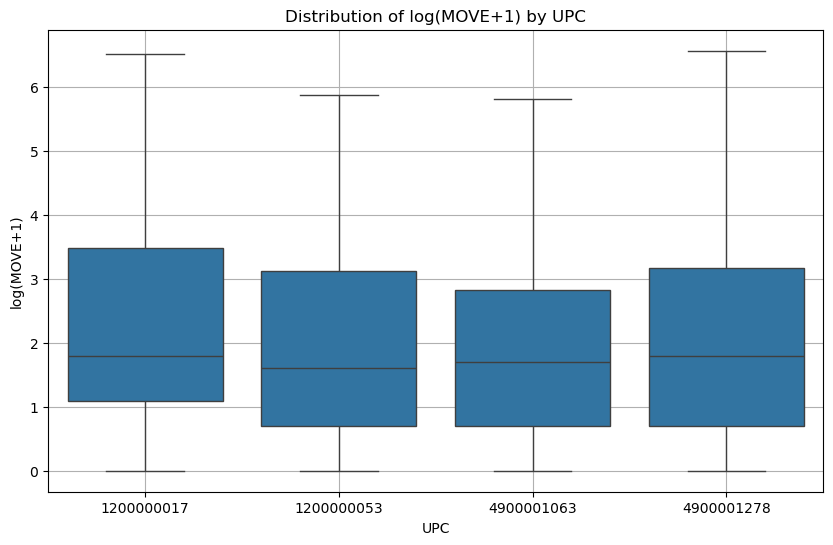

In [39]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df2, x='UPC', y='log_move')
plt.title('Distribution of log(MOVE+1) by UPC')
plt.xlabel('UPC')
plt.ylabel('log(MOVE+1)')
plt.grid(True)
plt.show()

### seasonality check: moderate yearly seasonality (number of week = 52)

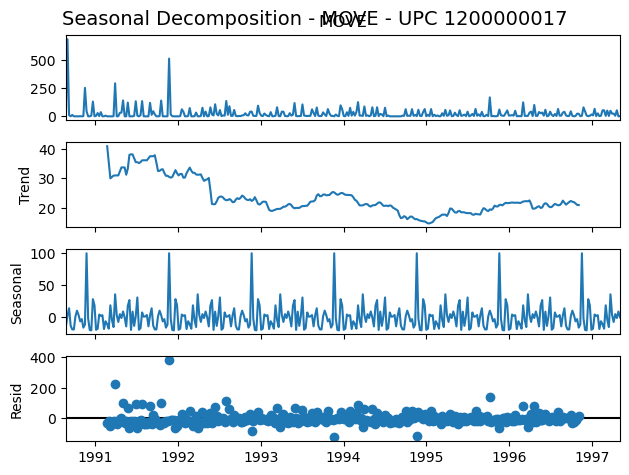

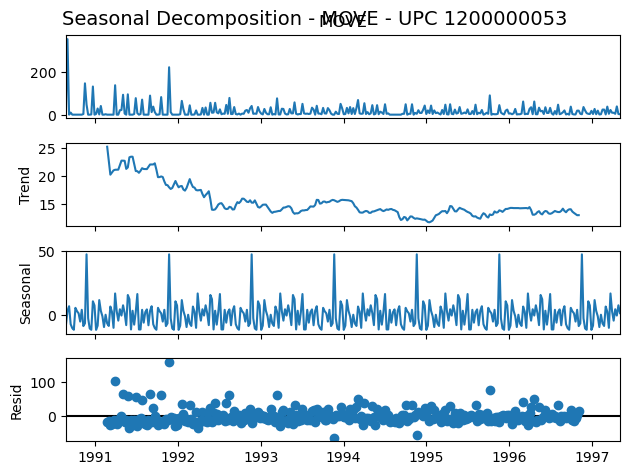

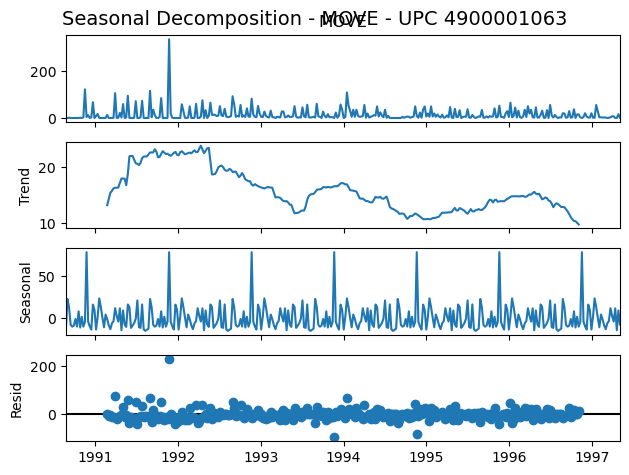

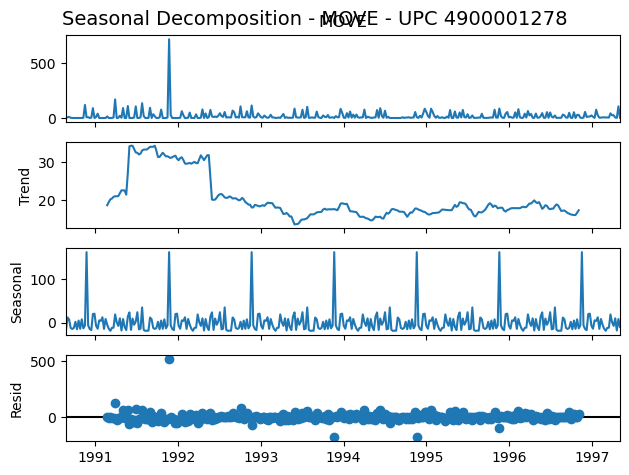

In [43]:
for upc in df['UPC'].unique():
    upc_data = df2[df2['UPC'] == upc]
    weekly_series = upc_data.set_index('WEEK')['MOVE']
    start_date = df2['DATE'].min()  
    weekly_series.index = pd.date_range(start=start_date, periods=len(weekly_series), freq='W')
    result = seasonal_decompose(weekly_series, model='additive', period=52)
    result.plot()
    plt.suptitle(f'Seasonal Decomposition - MOVE - UPC {upc}', fontsize=14)
    plt.show()

<Figure size 1000x400 with 0 Axes>

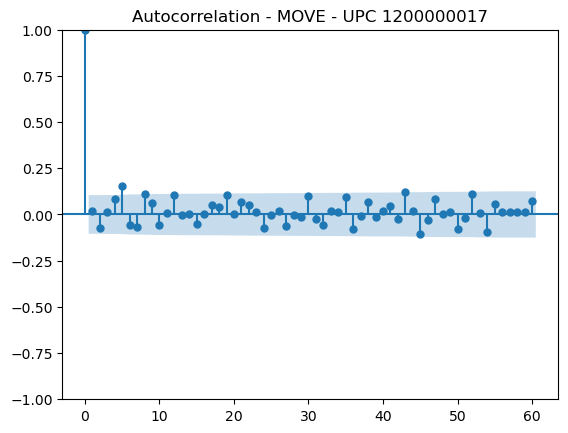

<Figure size 1000x400 with 0 Axes>

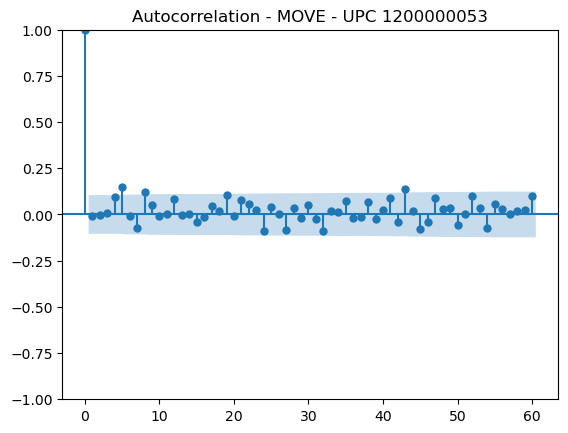

<Figure size 1000x400 with 0 Axes>

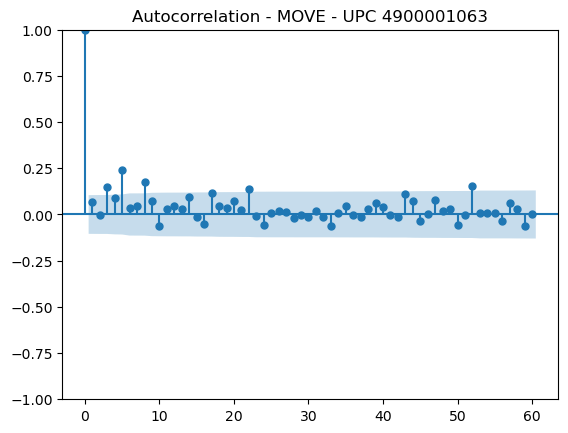

<Figure size 1000x400 with 0 Axes>

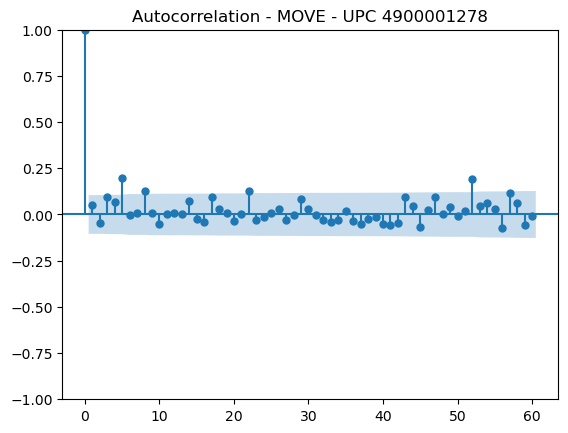

In [45]:
for upc in df['UPC'].unique():
    upc_data = df2[df2['UPC'] == upc].sort_values('WEEK')
    series = upc_data['log_move']  

    plt.figure(figsize=(10, 4))
    plot_acf(series, lags=60) 
    plt.title(f'Autocorrelation - MOVE - UPC {upc}')
    plt.show()

<Figure size 1000x400 with 0 Axes>

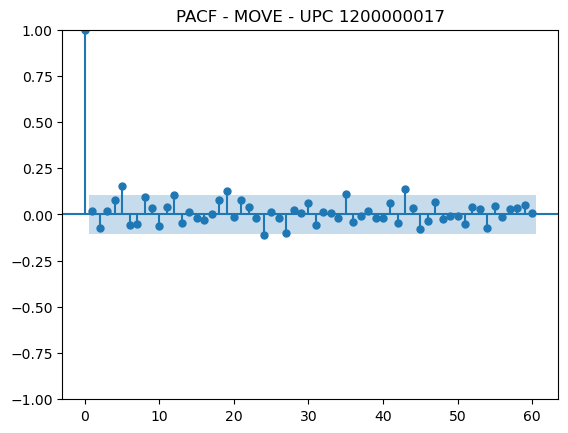

<Figure size 1000x400 with 0 Axes>

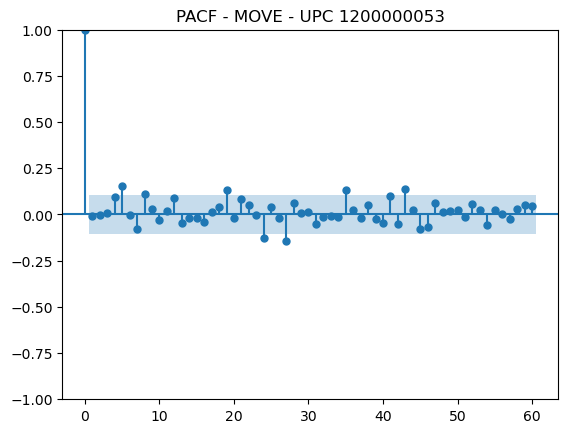

<Figure size 1000x400 with 0 Axes>

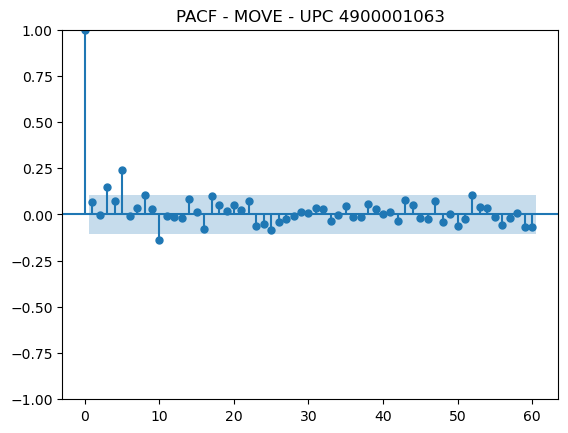

<Figure size 1000x400 with 0 Axes>

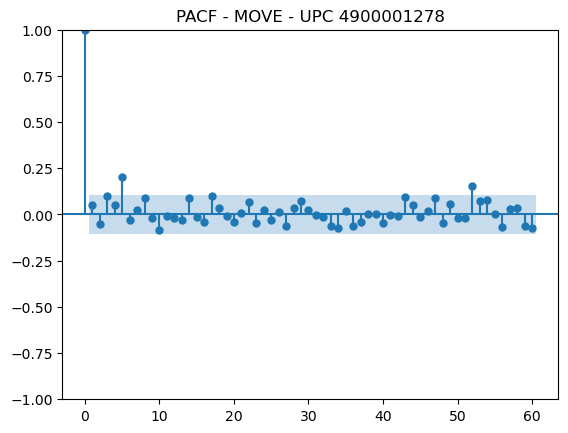

In [47]:
for upc in df['UPC'].unique():
    upc_data = df2[df2['UPC'] == upc].sort_values('WEEK')
    series = upc_data['log_move']  

    plt.figure(figsize=(10, 4))
    plot_pacf(series, lags=60) 
    plt.title(f'PACF - MOVE - UPC {upc}')
    plt.show()

# train-test split

In [49]:
df2['WEEK'].nunique()

350

In [51]:
test_period = 13  # 13 weeks, one quarter, assume quarterly price and promotion planning so that future price and promotion are planned and known
for upc in df['UPC'].unique():
    upc_data = df2[df2['UPC'] == upc].sort_values('WEEK')
    train_period = len(upc_data) - test_period
    train = upc_data[:train_period]
    test = upc_data[-test_period:]

    print(f"Train size: {len(train)}, Test size: {len(test)}")

Train size: 337, Test size: 13
Train size: 337, Test size: 13
Train size: 337, Test size: 13
Train size: 337, Test size: 13


In [53]:
for upc in df['UPC'].unique():
    upc_data = df2[df2['UPC'] == upc]
    print(len(upc_data[upc_data.log_move==0])/len(upc_data))

0.15142857142857144
0.2
0.19714285714285715
0.18857142857142858


# SARIMAX

In [55]:
exog = ['log_price_1200000017', 'log_price_1200000053', 'log_price_4900001063','log_price_4900001278', 
        'promo', 'PROFIT']

In [59]:
def fit_and_forecast_sarimax(df=df2, upc=upc, train_period=337, test_period=13,
                            exog=['log_price_1200000017', 'log_price_1200000053', 'log_price_4900001063','log_price_4900001278', 'promo', 'PROFIT'],
                            seasonal=True,
                            start_p=0, start_q=0, max_p=5, max_q=5,
                            start_P=0, start_Q=0, max_P=5, max_Q=5,
                            m=52):
    
    print(f"\n=== Fitting UPC: {upc} ===")
    upc_data = df[df['UPC'] == upc].sort_values('WEEK')
    train = upc_data[:train_period]
    test = upc_data[-test_period:]

    model = auto_arima(
        np.array(train['log_move']),
        exogenous=train[exog],
        start_p=start_p, start_q=start_q,
        max_p=max_p, max_q=max_q,
        seasonal=seasonal,
        start_P=start_P, start_Q=start_Q,
        max_P=max_P, max_Q=max_Q,
        m=m,
        stepwise=True,
        suppress_warnings=True,
        trace=True
    )
    
    return model

In [67]:
def plot_actual_forecast(model, upc, df, test_period):
    forecast_log = model.predict(n_periods=test_period)
    forecast = np.exp(forecast_log) - 1

    upc_data = df[df['UPC'] == upc].sort_values('WEEK')
    test = upc_data[-test_period:]
    train_end_idx = len(upc_data) - test_period
    train_end_date = upc_data.iloc[train_end_idx - 1]['DATE']
    
    actual = test['MOVE'].values

    rmse = np.sqrt(mean_squared_error(actual, forecast))
    mape = mean_absolute_percentage_error(actual + 1e-6, forecast + 1e-6) * 100

    print(f"RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")

    plt.figure(figsize=(12, 5))
    plt.plot(upc_data['DATE'], upc_data['MOVE'], label='Actual')
    plt.plot(test['DATE'], forecast, label='Forecast (Test Period)')
    plt.axvline(train_end_date, color='red', linestyle='--', label='Train/Test Split')

    plt.gca().xaxis.set_major_formatter(DateFormatter("%Y"))

    plt.title(f'UPC {upc} - Actual Sales with Forecast')
    plt.xlabel('Week')
    plt.ylabel('Unit Sales')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### store 2, Coca Cola, Regular, sales forecast

In [61]:
model_sarimax_1200000017 = fit_and_forecast_sarimax(upc=1200000017)


=== Fitting UPC: 1200000017 ===
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=1467.914, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=1385.580, Time=5.55 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=inf, Time=22.30 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=1465.914, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=1394.578, Time=0.06 sec
 ARIMA(1,1,0)(2,0,0)[52] intercept   : AIC=1387.125, Time=20.68 sec
 ARIMA(1,1,0)(1,0,1)[52] intercept   : AIC=1387.066, Time=10.87 sec
 ARIMA(1,1,0)(0,0,1)[52] intercept   : AIC=1385.085, Time=5.69 sec
 ARIMA(1,1,0)(0,0,2)[52] intercept   : AIC=1387.069, Time=20.37 sec
 ARIMA(1,1,0)(1,0,2)[52] intercept   : AIC=1389.073, Time=23.83 sec
 ARIMA(0,1,0)(0,0,1)[52] intercept   : AIC=1463.520, Time=8.77 sec
 ARIMA(2,1,0)(0,0,1)[52] intercept   : AIC=1342.568, Time=6.77 sec
 ARIMA(2,1,0)(0,0,0)[52] intercept   : AIC=1345.563, Time=0.11 sec
 ARIMA(2,1,0)(1,0,1)[52] intercept   : AIC=1344.462, 

In [63]:
print(model_sarimax_1200000017.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  337
Model:             SARIMAX(2, 1, 1)x(0, 0, 1, 52)   Log Likelihood                -615.986
Date:                            Wed, 21 May 2025   AIC                           1241.973
Time:                                    20:31:59   BIC                           1261.058
Sample:                                         0   HQIC                          1249.581
                                            - 337                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0021      0.058     -0.035      0.972      -0.116       0.112
ar.L2         -0.0916      0.059   

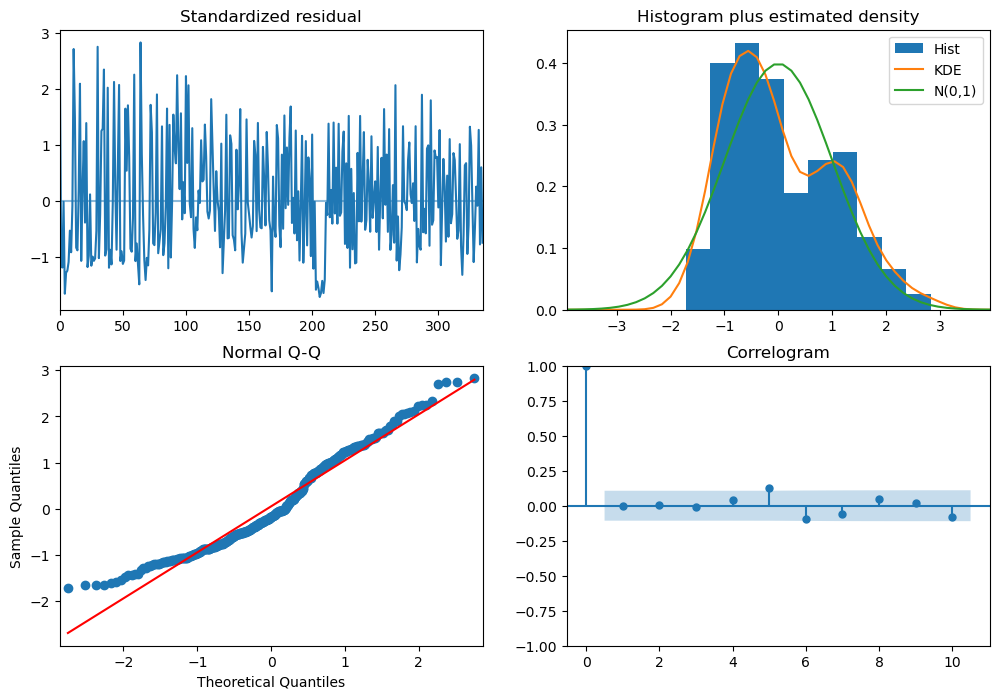

In [65]:
model_sarimax_1200000017.plot_diagnostics(figsize=(12, 8))
plt.show()

RMSE: 27.38, MAPE: 64596582.50%


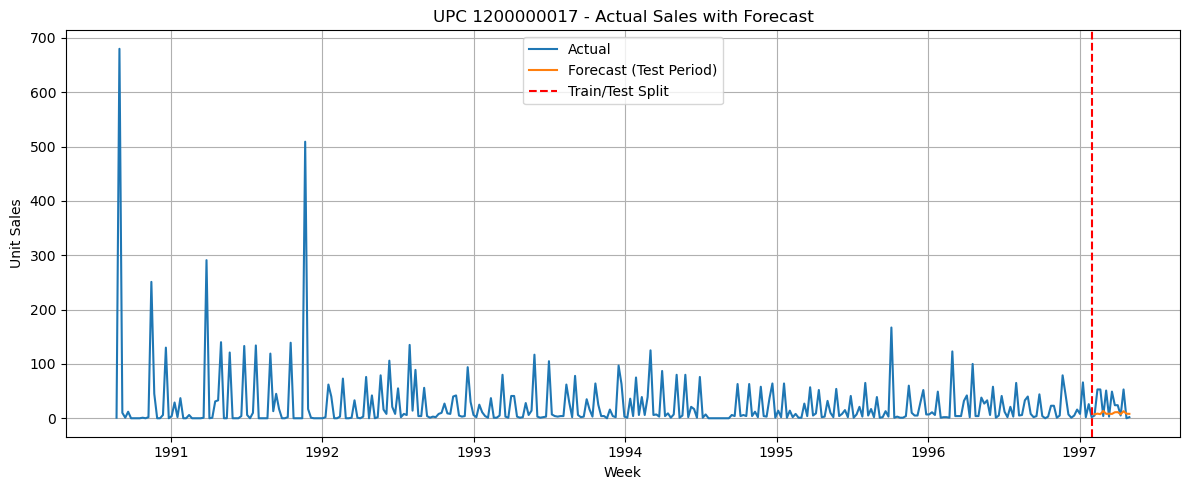

In [69]:
plot_actual_forecast(model_sarimax_1200000017,1200000017,df2,13)

### store 2, Coca Cola, Diet, sales forecast

In [71]:
model_sarimax_1200000053 = fit_and_forecast_sarimax(upc=1200000053)


=== Fitting UPC: 1200000053 ===
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=1418.480, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=1319.120, Time=5.56 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=inf, Time=21.38 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=1416.480, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=1325.050, Time=0.07 sec
 ARIMA(1,1,0)(2,0,0)[52] intercept   : AIC=1320.140, Time=20.79 sec
 ARIMA(1,1,0)(1,0,1)[52] intercept   : AIC=1320.416, Time=10.04 sec
 ARIMA(1,1,0)(0,0,1)[52] intercept   : AIC=1318.493, Time=5.34 sec
 ARIMA(1,1,0)(0,0,2)[52] intercept   : AIC=1320.380, Time=20.43 sec
 ARIMA(1,1,0)(1,0,2)[52] intercept   : AIC=inf, Time=140.76 sec
 ARIMA(0,1,0)(0,0,1)[52] intercept   : AIC=1417.381, Time=9.01 sec
 ARIMA(2,1,0)(0,0,1)[52] intercept   : AIC=1284.760, Time=5.51 sec
 ARIMA(2,1,0)(0,0,0)[52] intercept   : AIC=1287.037, Time=0.11 sec
 ARIMA(2,1,0)(1,0,1)[52] intercept   : AIC=1286.710, Time

In [72]:
print(model_sarimax_1200000053.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  337
Model:             SARIMAX(5, 1, 1)x(0, 0, 1, 52)   Log Likelihood                -584.911
Date:                            Wed, 21 May 2025   AIC                           1185.823
Time:                                    21:09:11   BIC                           1216.360
Sample:                                         0   HQIC                          1197.996
                                            - 337                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0350      0.053     -0.658      0.511      -0.139       0.069
ar.L2         -0.0107      0.060   

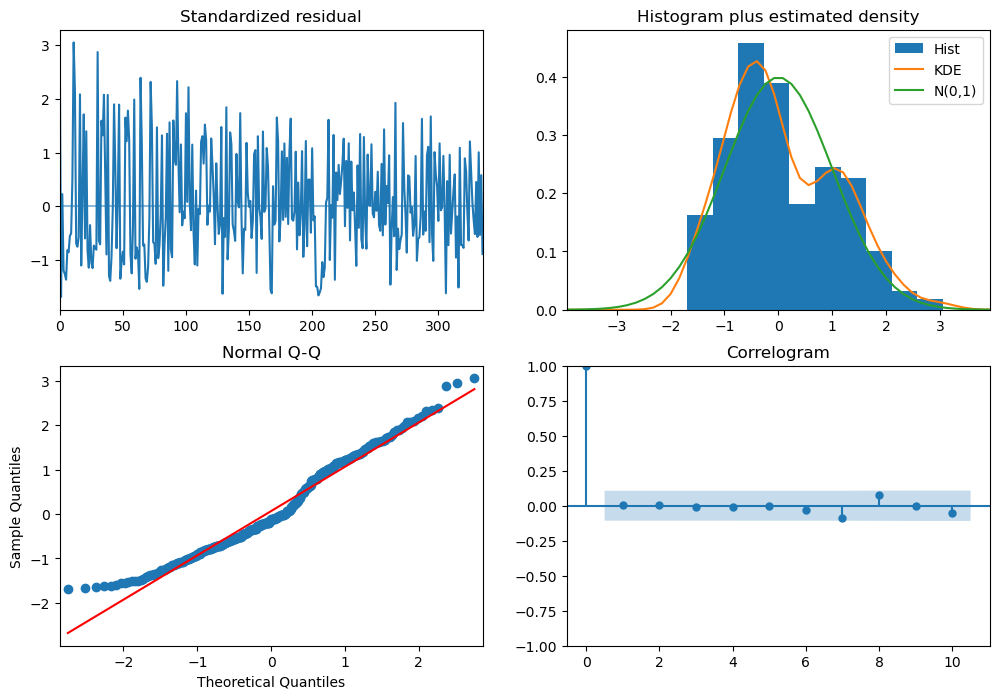

In [73]:
model_sarimax_1200000053.plot_diagnostics(figsize=(12, 8))
plt.show()

RMSE: 15.19, MAPE: 142.29%


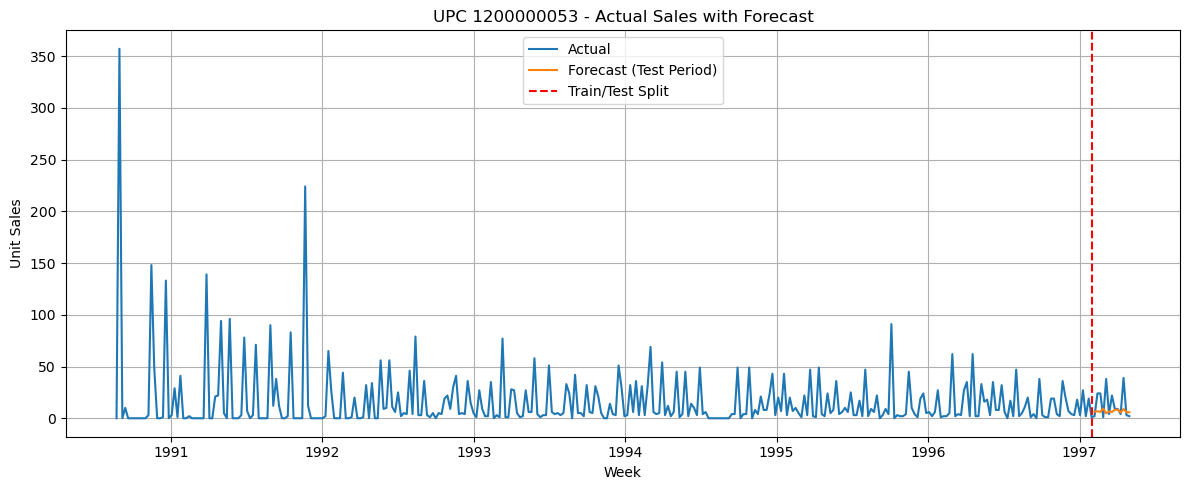

In [74]:
plot_actual_forecast(model_sarimax_1200000053,1200000053,df2,13)

### store 2, PEPSI, Regular, sales forecast

In [79]:
model_sarimax_4900001063 = fit_and_forecast_sarimax(upc=4900001063)


=== Fitting UPC: 4900001063 ===
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=1382.181, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=1292.101, Time=4.98 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=1155.226, Time=10.63 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=1380.182, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=1163.388, Time=0.19 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=1157.075, Time=13.03 sec
 ARIMA(0,1,1)(0,0,2)[52] intercept   : AIC=1157.093, Time=64.14 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AIC=1155.088, Time=11.94 sec
 ARIMA(0,1,1)(2,0,0)[52] intercept   : AIC=1157.077, Time=51.83 sec
 ARIMA(0,1,1)(2,0,1)[52] intercept   : AIC=1159.073, Time=55.64 sec
 ARIMA(0,1,0)(1,0,0)[52] intercept   : AIC=1373.949, Time=4.10 sec
 ARIMA(1,1,1)(1,0,0)[52] intercept   : AIC=1156.935, Time=15.93 sec
 ARIMA(0,1,2)(1,0,0)[52] intercept   : AIC=1156.894, Time=14.56 sec
 ARIMA(1,1,2)(1,0,0)[52] intercept   : AIC=11

In [80]:
print(model_sarimax_4900001063.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  337
Model:             SARIMAX(1, 1, 3)x(1, 0, [], 52)   Log Likelihood                -569.593
Date:                             Wed, 21 May 2025   AIC                           1151.186
Time:                                     21:50:15   BIC                           1174.089
Sample:                                          0   HQIC                          1160.316
                                             - 337                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6717      0.173     -3.882      0.000      -1.011      -0.333
ma.L1         -0.2793      

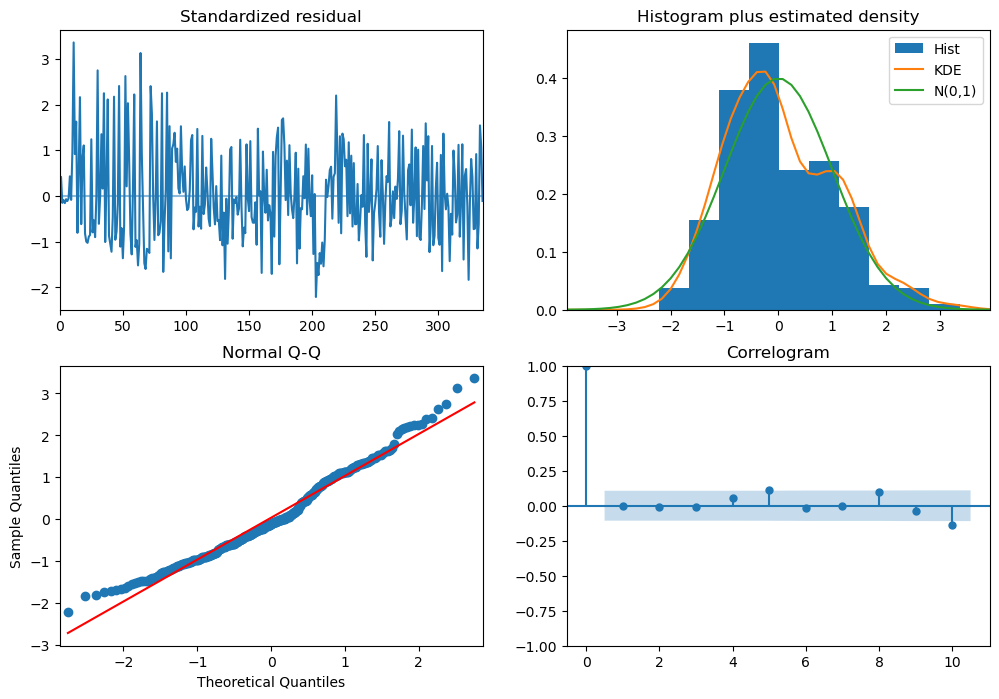

In [81]:
model_sarimax_4900001063.plot_diagnostics(figsize=(12, 8))
plt.show()

In [127]:
def plot_actual_forecast(model, upc, df, test_period):
    forecast_log = model.predict(n_periods=test_period)
    forecast = np.exp(forecast_log) - 1

    upc_data = df[df['UPC'] == upc].sort_values('WEEK')
    test = upc_data[-test_period:]
    train_end_idx = len(upc_data) - test_period
    train_end_date = upc_data.iloc[train_end_idx - 1]['DATE']
    
    actual = test['MOVE'].values

    rmse = np.sqrt(mean_squared_error(actual, forecast))
    mape = mean_absolute_percentage_error(actual + 1e-6, forecast + 1e-6) * 100

    print(f"RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")

    plt.figure(figsize=(12, 5))
    plt.plot(upc_data['DATE'], upc_data['MOVE'], label='Actual')
    plt.plot(test['DATE'], forecast, label='Forecast (Test Period)')
    plt.axvline(train_end_date, color='red', linestyle='--', label='Train/Test Split')

    plt.gca().xaxis.set_major_formatter(DateFormatter("%Y"))

    plt.title(f'UPC {upc} - Actual Sales with Forecast')
    plt.xlabel('Week')
    plt.ylabel('Unit Sales')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

RMSE: 4.66, MAPE: 135366709.95%


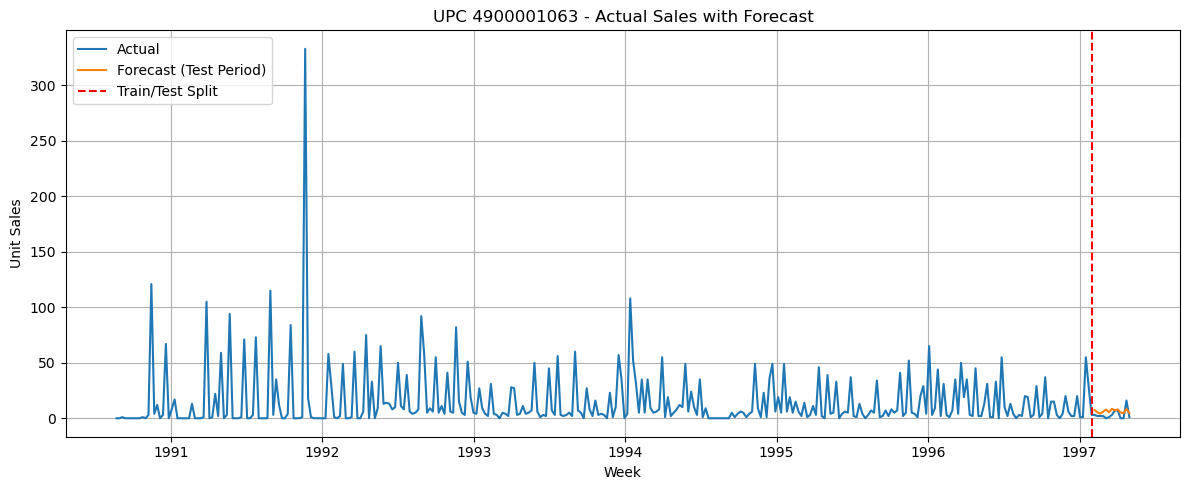

In [82]:
plot_actual_forecast(model_sarimax_4900001063,4900001063,df2,13)

### store 2, PEPSI, Diet, sales forecast

In [83]:
model_sarimax_4900001278 = fit_and_forecast_sarimax(upc=4900001278)


=== Fitting UPC: 4900001278 ===
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=1431.155, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=1352.002, Time=5.06 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=1206.473, Time=14.52 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=1429.157, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=1217.641, Time=0.21 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=1208.213, Time=21.94 sec
 ARIMA(0,1,1)(0,0,2)[52] intercept   : AIC=1208.207, Time=80.70 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AIC=1206.247, Time=13.89 sec
 ARIMA(0,1,1)(2,0,0)[52] intercept   : AIC=1208.210, Time=104.17 sec
 ARIMA(0,1,1)(2,0,1)[52] intercept   : AIC=1210.214, Time=70.41 sec
 ARIMA(0,1,0)(1,0,0)[52] intercept   : AIC=1423.358, Time=4.38 sec
 ARIMA(1,1,1)(1,0,0)[52] intercept   : AIC=1208.187, Time=21.08 sec
 ARIMA(0,1,2)(1,0,0)[52] intercept   : AIC=1208.170, Time=17.90 sec
 ARIMA(1,1,2)(1,0,0)[52] intercept   : AIC=1

In [84]:
print(model_sarimax_4900001278.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  337
Model:             SARIMAX(0, 1, 1)x(1, 0, [], 52)   Log Likelihood                -599.886
Date:                             Wed, 21 May 2025   AIC                           1205.771
Time:                                     21:58:34   BIC                           1217.222
Sample:                                          0   HQIC                          1210.336
                                             - 337                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9688      0.017    -56.066      0.000      -1.003      -0.935
ar.S.L52       0.2191      

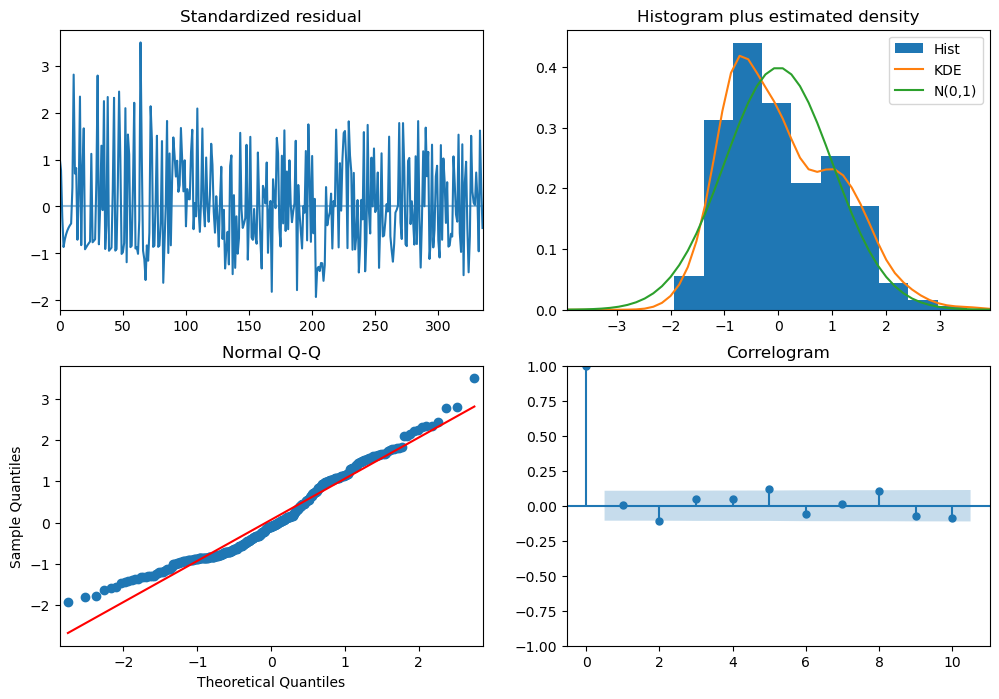

In [85]:
model_sarimax_4900001278.plot_diagnostics(figsize=(12, 8))
plt.show()

RMSE: 27.75, MAPE: 142.03%


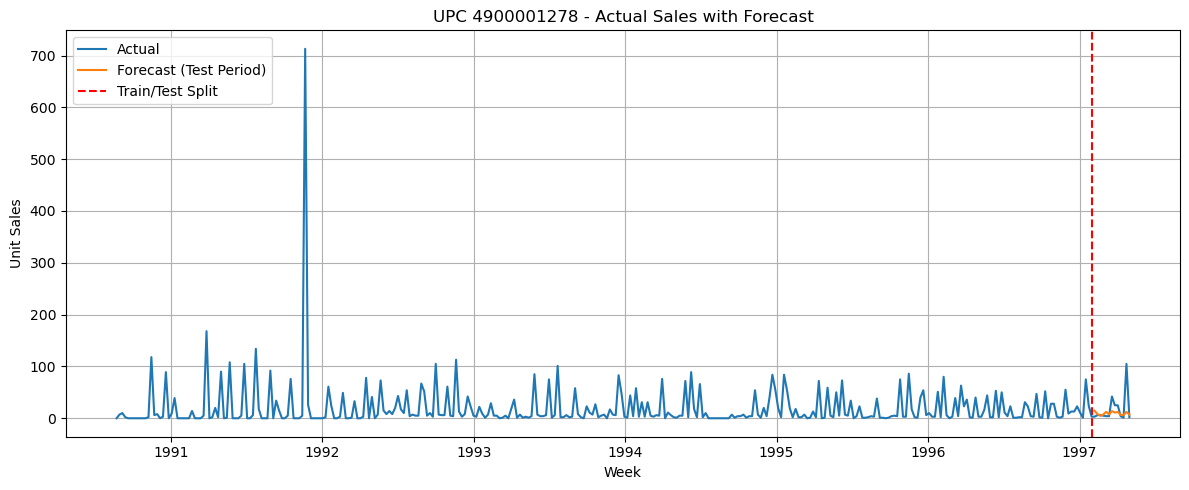

In [86]:
plot_actual_forecast(model_sarimax_4900001278,4900001278,df2,13)